# GDP and Life Expectancy 2018 Comparison

Richer countries can afford to invest more on healthcare, on work and road safety, and other measures that reduce mortality. On the other hand, richer countries may have less healthy lifestyles. Is there any relation between the wealth of a country and the life expectancy of its inhabitants?

The following analysis checks whether there is any correlation between the total gross domestic product (GDP) of a country in 2018 and the life expectancy of people born in that country in 2018.

## Getting the data

Two datasets of the World Bank are considered. One dataset, available at <http://data.worldbank.org/indicator/NY.GDP.MKTP.CD>, lists the GDP of the world's countries in current US dollars, for various years. The use of a common currency allows us to compare GDP values across countries. The other dataset, available at <http://data.worldbank.org/indicator/SP.DYN.LE00.IN>, lists the life expectancy of the world's countries. The datasets were downloaded as Excel files in June 2021.

In [24]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

import pandas as pd

YEAR = 2018
GDP_INDICATOR = 'NY.GDP.MKTP.CD'
gdpReset = pd.read_excel('WB GDP 2020.xls')

LIFE_INDICATOR = 'SP.DYN.LE00.IN'
lifeReset = pd.read_excel('WB LE 2020.xls')
lifeReset.head()

,Country Name,year,SP.DYN.LE00.IN
0,Afghanistan,2018,64.486
1,Albania,2018,78.458
2,Algeria,2018,76.693
3,American Samoa,2018,NaN
4,Andorra,2018,NaN


## Cleaning the data

Inspecting the data with `head()` and `tail()` shows:

1.  aggregated data, for the Arab World, the Caribbean small states, and other country groups used by the World Bank;
- GDP and life expectancy values are missing for some countries.

The data is therefore cleaned by:
- removing rows with unavailable values.
- filtering data set to ensure the first selected rows are stricly countries

In [25]:
gdpCountries = gdpReset.dropna()
lifeCountries = lifeReset.dropna()

## Transforming the data

The World Bank reports GDP in US dollars and cents. To make the data easier to read, the GDP is converted to millions of British pounds (the author's local currency) with the following auxiliary functions, using the average 2018 dollar-to-pound conversion rate provided by <http://www.ukforex.co.uk/forex-tools/historical-rate-tools/yearly-average-rates>. 

In [26]:
gdpCountries.head()

,Country Name,Year,NY.GDP.MKTP.CD
0,Afghanistan,2018,1.835388e+10
1,Albania,2018,1.514702e+10
2,Algeria,2018,1.754057e+11
3,American Samoa,2018,6.360000e+08
4,Andorra,2018,3.218316e+09


In [27]:
def roundToMillions (value):
    return round(value / 1000000)

def usdToGBP (usd):
    return usd / 1.334801

GDP = 'GDP (£m)'
gdpCountries[GDP] = gdpCountries[GDP_INDICATOR].apply(usdToGBP).apply(roundToMillions)
gdpCountries.head()

<ipython-input-27-a8f6c23dc95c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdpCountries[GDP] = gdpCountries[GDP_INDICATOR].apply(usdToGBP).apply(roundToMillions)


,Country Name,Year,NY.GDP.MKTP.CD,GDP (£m)
0,Afghanistan,2018,1.835388e+10,13750
1,Albania,2018,1.514702e+10,11348
2,Algeria,2018,1.754057e+11,131410
3,American Samoa,2018,6.360000e+08,476
4,Andorra,2018,3.218316e+09,2411


The unnecessary columns can be dropped.

In [28]:
COUNTRY = 'Country Name'
headings = [COUNTRY, GDP]
gdpClean = gdpCountries[headings]
gdpClean.head()

,Country Name,GDP (£m)
0,Afghanistan,13750
1,Albania,11348
2,Algeria,131410
3,American Samoa,476
4,Andorra,2411


The World Bank reports the life expectancy with several decimal places. After rounding, the original column is discarded.

In [29]:
LIFE = 'Life expectancy (years)'
lifeCountries[LIFE] = lifeCountries[LIFE_INDICATOR].apply(round)
headings = [COUNTRY, LIFE]
lifeClean = lifeCountries[headings]
lifeClean.head()

<ipython-input-29-62070c039e83>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lifeCountries[LIFE] = lifeCountries[LIFE_INDICATOR].apply(round)


,Country Name,Life expectancy (years)
0,Afghanistan,64
1,Albania,78
2,Algeria,77
5,Angola,61
6,Antigua and Barbuda,77


## Combining the data

The tables are combined through an inner join on the common 'country' column. 

In [30]:
gdpVsLife = pd.merge(gdpClean, lifeClean, on=COUNTRY, how='inner')
gdpVsLife.head()

,Country Name,GDP (£m),Life expectancy (years)
0,Afghanistan,13750,64
1,Albania,11348,78
2,Algeria,131410,77
3,Angola,75931,61
4,Antigua and Barbuda,1203,77


## Calculating the correlation

To measure if the life expectancy and the GDP grow together, the Spearman rank correlation coefficient is used. It is a number from -1 (perfect inverse rank correlation: if one indicator increases, the other decreases) to 1 (perfect direct rank correlation: if one indicator increases, so does the other), with 0 meaning there is no rank correlation. A perfect correlation doesn't imply any cause-effect relation between the two indicators. A p-value below 0.05 means the correlation is statistically significant.

In [31]:
from scipy.stats import spearmanr

gdpColumn = gdpVsLife[GDP]
lifeColumn = gdpVsLife[LIFE]
(correlation, pValue) = spearmanr(gdpColumn, lifeColumn)
print('The correlation is', correlation)
if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

The correlation is 0.3307100000921487
It is statistically significant.


The value shows a direct correlation, i.e. richer countries tend to have longer life expectancy, but it is not a very strong correlation.

## Showing the data

Measures of correlation can be misleading, so it is best to see the overall picture with a scatterplot. The GDP axis uses a logarithmic scale to better display the vast range of GDP values, from a few million to several billion (million of million) pounds.

<AxesSubplot:xlabel='GDP (£m)', ylabel='Life expectancy (years)'>

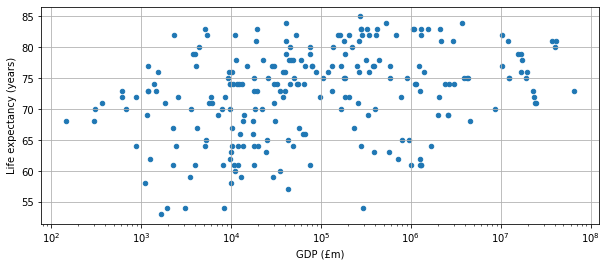

In [32]:
%matplotlib inline
gdpVsLife.plot(x=GDP, y=LIFE, kind='scatter', grid=True, logx=True, figsize=(10, 4))

The plot shows there is no clear correlation: similar to 2013 results,there are rich countries with low life expectancy, poor countries with high expectancy, and countries with around 10 thousand (10<sup>4</sup>) million pounds GDP have almost the full range of values, from below 50 to over 80 years. Towards the lower and higher end of GDP, the variation diminishes. Above 40 thousand million pounds of GDP (3rd tick mark to the right of 10<sup>4</sup>), most countries have an expectancy of 70 years or more, whilst below that threshold most countries' life expectancy is below 70 years. 

Comparing the 10 poorest countries and the 10 countries with the lowest life expectancy shows that total GDP is not the most accurate measure

In [33]:
# the 10 countries with lowest GDP
gdpVsLife.sort_values(GDP).head(10)

,Country Name,GDP (£m),Life expectancy (years)
109,Kiribati,147,68
141,"Micronesia, Fed. Sts.",301,68
182,Sao Tome and Principe,309,70
212,Tonga,367,71
199,St. Vincent and the Grenadines,608,72
181,Samoa,615,73
225,Vanuatu,685,70
79,Grenada,876,72
40,Comoros,883,64
83,Guinea-Bissau,1093,58


In [34]:
# the 10 countries with lowest life expectancy
gdpVsLife.sort_values(LIFE).head(10)

,Country Name,GDP (£m),Life expectancy (years)
34,Central African Republic,1664,53
122,Lesotho,1930,54
36,Chad,8420,54
187,Sierra Leone,3060,54
158,Nigeria,297565,54
44,Cote d'Ivoire,43461,57
59,Equatorial Guinea,9948,58
83,Guinea-Bissau,1093,58
61,Eswatini,3495,59
31,Cameroon,28989,59


## Conclusions

In this current year there is no strong correlation between a country's wealth and the life expectancy of its inhabitants: there is often a wide variation of life expectancy for countries with similar GDP, countries with the lowest life expectancy are not the poorest countries, and countries with the highest expectancy are not the richest countries. the relationship is hard to define, because the vast majority of countries with a life expectancy below 70 years are scattered almost evenly on the scatterplot.

Recommendation: Using the [NY.GDP.PCAP.PP.CD](http://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD) indicator, GDP per capita in current 'international dollars', might possibly make for a better like-for-like comparison between countries, because it would take population and purchasing power into account. Using more specific data, like expediture on health, could also lead to a better analysis.

## TASK HAS BEEN COMPLETED 2018 GDP vs LE COMPARISONS


## THE END!